In [1]:
import numpy as np
from PIL import Image
from skimage import measure
from matplotlib import pyplot as plt

In [2]:
testim= np.asarray(Image.open('/media/sgr/storage/cob_tf/demo/test_segm.png'))
_=testim[:,:,0]*1000000+testim[:,:,1]*1000+testim[:,:,2]
all_labels=measure.label(_)

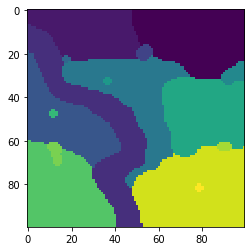

In [116]:
plt.imshow(all_labels)

In [105]:
def get_segments_table(segment_map, image):
    '''
    segment_map - indexed connected pixels groups where 0 - labeling masked area
    '''
    from skimage import measure
    from scipy import ndimage
    import pandas as pd    
    h,w,d=image.shape    
    index, reg_area = np.unique(segment_map,return_counts=True)    
    
    coord_lists=[(segment_map.ravel()==ind).nonzero()[0] for ind in index] 
    
    region_means=[np.array(i) for i in zip(*[ndimage.mean(image[:,:,band], labels=segment_map, index=index) for band in range(d)])]    
    return {index[i]: [reg_area[i], region_means[i]] for i in range (len(index))}

def get_board(segmented):
    "return boarder's length" 
    from scipy.signal import correlate2d
    kernel=[[0,1,0],[1,0,1],[0,1,0]]
    outlist={}
    for idx in np.unique(segmented):    
        corr=correlate2d((segmented==idx),kernel,mode='same')
        bord=corr*(segmented!=idx)        
        outlist[idx]= [(zone,np.sum(bord[(segmented==zone) & (bord>0)])) for zone in np.unique(segmented[bord>0])]
    return outlist

def get_dist(fv1,fv2):
    return np.sum((fv1-fv2)**2)

def get_neighbs_table(all_labels, thresh=100, zero_is_mask=True):
    thresh=thresh
    jj= get_board(all_labels)
    outdict={}
    for key in jj:
        if key==0 and zero_is_mask:
            continue
        for kk, lent in jj[key]:
            if kk==0 and zero_is_mask:
                continue
            areas=np.array([hhh[key][0],hhh[kk][0]])     

            if kk>key and np.min(areas)<thresh:
                features= np.array([hhh[key][1],hhh[kk][1]]) 
                dist=get_dist(*features)
                metr=(np.sum(areas)/np.prod(areas))*dist/lent
                outdict[(key, kk)]=[metr,lent]
    return outdict

def clear_merger (merge_list):
    merger=[[],[]]
    for i in merge_list[::-1]:
        if i[0] in merger[1]:            
            merger[0].append(merger[0][merger[1].index(i[0])])
            merger[1].append(i[1])
        else: 
            merger[0].append(i[0])
            merger[1].append(i[1])
    return merger

def get_clear_segm(all_labels, testim, thresh=100, zero_is_mask=True):
    hhh=get_segments_table(all_labels, testim)
    outdict=get_neighbs_table(all_labels, thresh, zero_is_mask)
    merger=[]
    
    while len(outdict)>0:
        minind=np.argmin(np.array(list(outdict.values()))[:,0])
        minpair=list(outdict.keys())[minind]
        merger.append(minpair)

        p,q=minpair
        ap, fp=hhh[p]
        aq, fq=hhh[q]
        hhh[p]=[ap+aq, (ap*fp+aq*fq)/(ap+aq)]


        for pair in [pair for pair in outdict if q in pair]:    
            pair_new = tuple([p if x==q else x for x in pair])
            if pair_new[0]==pair_new[1]: # выкинули старую пару
                outdict.pop(pair)
                continue    
            elif outdict.get(pair_new): # если пара с таким индексом уже существует
                lent=outdict[pair_new][1]+outdict[pair][1]        
            else: # если такого индекса не существует
                lent=outdict[pair][1]
                outdict.pop(pair)

            key,kk=pair_new

            features= np.array([hhh[key][1],hhh[kk][1]]) 
            dist=get_dist(*features)
            areas=np.array([hhh[key][0],hhh[kk][0]])
            metr=(np.sum(areas)/np.prod(areas))*dist/lent
            outdict[(key, kk)]=[metr,lent] 
            
            if np.min(areas)>thresh:
                outdict.pop(pair_new)
                
    all_label1=np.copy(all_labels)
   
    for i in zip(*clear_merger(merger)):        
        all_label1[all_label1==i[1]]=i[0] 
    return all_label1

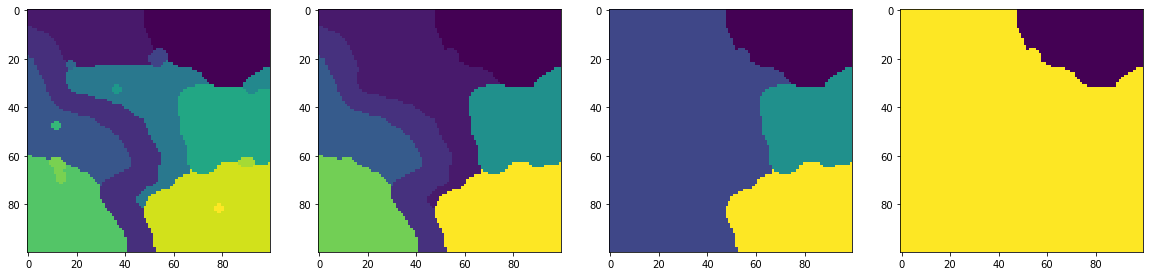

In [114]:
plt.figure(figsize=(20,15))
for num, thresh in enumerate([10,100,1000,10000],1):
    plt.subplot(1,4,num)
    plt.imshow(get_clear_segm(all_labels, testim, thresh))



# plt.imshow(get_clear_segm(all_labels, testim, thresh=0))

In [115]:
%timeit get_clear_segm(all_labels, testim, thresh=200)

6.96 ms ± 7.48 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
jj= get_board(all_labels)
outdict={}
for key in jj:
    for kk, lent in jj[key]:
        if kk>key:
            outdict[(key, kk)]=lent

In [119]:
outdict

{(0, 1): 21,
 (0, 3): 12,
 (0, 6): 27,
 (0, 7): 19,
 (0, 9): 15,
 (1, 2): 31,
 (1, 3): 9,
 (1, 5): 8,
 (1, 6): 32,
 (2, 4): 110,
 (2, 5): 4,
 (2, 6): 110,
 (2, 11): 38,
 (2, 14): 23,
 (3, 6): 11,
 (4, 10): 16,
 (4, 11): 34,
 (4, 12): 11,
 (5, 6): 4,
 (6, 8): 16,
 (6, 9): 53,
 (6, 14): 35,
 (7, 9): 16,
 (9, 13): 12,
 (9, 14): 34,
 (11, 12): 27,
 (13, 14): 10,
 (14, 15): 16}

In [30]:
def clear_segment_map(segment_map, image, area_thresh=5):
    '''
    segment_map - indexed connected pixels groups where 0 - labeling masked area
    '''
    from skimage import measure
    from scipy import ndimage
    import pandas as pd    
    h,w,d=image.shape    
    index, reg_area = np.unique(segment_map,return_counts=True)    
    
    coord_lists=[(segment_map.ravel()==ind).nonzero()[0] for ind in index] 
    
    region_means=[np.array(i) for i in zip(*[ndimage.mean(image[:,:,band], labels=segment_map, index=index) for band in range(d)])]    
    return {index[i]: [reg_area[i], region_means[i]] for i in range (len(index))}

#     return pd.DataFrame({'index':index, 'area':reg_area, 'pixels':coord_lists, 'features':region_means})   
#     return {'index':index, 'area':reg_area, 'pixels':coord_lists, 'features':region_means}  

In [31]:
hhh=clear_segment_map(all_labels, testim)
hhh

{0: [1304, array([0., 0., 0.])],
 1: [962, array([56., 52., 39.])],
 2: [1318, array([39., 39., 56.])],
 3: [46, array([ 49., 150.,  32.])],
 4: [990, array([44., 48., 37.])],
 5: [12, array([72., 69., 17.])],
 6: [1228, array([44., 56., 39.])],
 7: [81, array([ 49., 150.,  32.])],
 8: [12, array([72., 69., 17.])],
 9: [1156, array([91., 76., 29.])],
 10: [12, array([ 49., 150.,  32.])],
 11: [1187, array([38., 43., 31.])],
 12: [51, array([ 49., 150.,  32.])],
 13: [24, array([72., 69., 17.])],
 14: [1605, array([56., 52., 39.])],
 15: [12, array([72., 69., 17.])]}

In [32]:
def get_dist(fv1,fv2):
    return np.sum((fv1-fv2)**2)

thresh=100
jj= get_board(all_labels)
outdict={}
for key in jj:
    for kk, lent in jj[key]:
        areas=np.array([hhh[key][0],hhh[kk][0]])      
        
        
        if kk>key and np.min(areas)<thresh:
            features= np.array([hhh[key][1],hhh[kk][1]])           
            
#             features= hhh[hhh['id'].isin([key, kk])]['features'].values
            dist=get_dist(*features)
            metr=(np.sum(areas)/np.prod(areas))*dist/lent
#             outdict[(key, kk)]=[list(areas),metr,lent]
            outdict[(key, kk)]=[metr,lent]

In [33]:
outdict

{(0, 3): [48.62234095758868, 12],
 (0, 7): [17.891729650757203, 19],
 (1, 3): [24.55536472927777, 9],
 (1, 5): [10.85245582120582, 8],
 (2, 5): [73.79078148710167, 4],
 (3, 6): [18.268304772695085, 11],
 (4, 10): [55.10789141414141, 16],
 (4, 12): [19.594544374223517, 11],
 (5, 6): [30.23004885993485, 4],
 (6, 8): [7.557512214983713, 16],
 (7, 9): [5.985286775385536, 16],
 (9, 13): [1.9635476739715492, 12],
 (11, 12): [8.764091015044977, 27],
 (13, 14): [4.351612149532711, 10],
 (14, 15): [5.399445093457944, 16]}

In [34]:
while len(outdict)>0:
    minind=np.argmin(np.array(list(outdict.values()))[:,0])
    minpair=list(outdict.keys())[minind]
    merger.append(minpair)

    p,q=minpair
    ap, fp=hhh[p]
    aq, fq=hhh[q]
    hhh[p]=[ap+aq, (ap*fp+aq*fq)/(ap+aq)]


    for pair in [pair for pair in outdict if q in pair]:    
        pair_new = tuple([p if x==q else x for x in pair])
        if pair_new[0]==pair_new[1]: # выкинули старую пару
            outdict.pop(pair)
            continue    
        elif outdict.get(pair_new): # если пара с таким индексом уже существует
            lent=outdict[pair_new][1]+outdict[pair][1]        
        else: # если такого индекса не существует
            lent=outdict[pair][1]
            outdict.pop(pair)

        key,kk=pair_new

        features= np.array([hhh[key][1],hhh[kk][1]]) 
        dist=get_dist(*features)
        metr=(np.sum(areas)/np.prod(areas))*dist/lent
        outdict[(key, kk)]=[metr,lent] 
        areas=np.array([hhh[key][0],hhh[kk][0]])
        if np.min(areas)>thresh:
            outdict.pop(pair_new)


In [22]:
# np.fromiter(outdict.values(), dtype=float)
minind=np.argmin(np.array(list(outdict.values()))[:,0])
minpair=list(outdict.keys())[minind]
merger.append(minpair)
# np.fromiter(outdict.values(), dtype=float)

In [23]:
p,q=minpair
ap, fp=hhh[p]
aq, fq=hhh[q]
hhh[p]=[ap+aq, (ap*fp+aq*fq)/(ap+aq)]

In [24]:
for pair in [pair for pair in outdict if q in pair]:    
    pair_new = tuple([p if x==q else x for x in pair])
    if pair_new[0]==pair_new[1]: # выкинули старую пару
        outdict.pop(pair)
        continue    
    elif outdict.get(pair_new): # если пара с таким индексом уже существует
        lent=outdict[pair_new][1]+outdict[pair][1]        
    else: # если такого индекса не существует
        lent=outdict[pair][1]
        outdict.pop(pair)
    
    key,kk=pair_new
      
    features= np.array([hhh[key][1],hhh[kk][1]]) 
    dist=get_dist(*features)
    metr=(np.sum(areas)/np.prod(areas))*dist/lent
    outdict[(key, kk)]=[metr,lent] 
    areas=np.array([hhh[key][0],hhh[kk][0]])
    if np.min(areas)>thresh:
        outdict.pop(pair_new)

In [38]:
def clear_merger (merge_list):
    merger=[[],[]]
    for i in merge_list[::-1]:
        if i[0] in merger[1]:            
            merger[0].append(merger[0][merger[1].index(i[0])])
            merger[1].append(i[1])
        else: 
            merger[0].append(i[0])
            merger[1].append(i[1])
    return merger

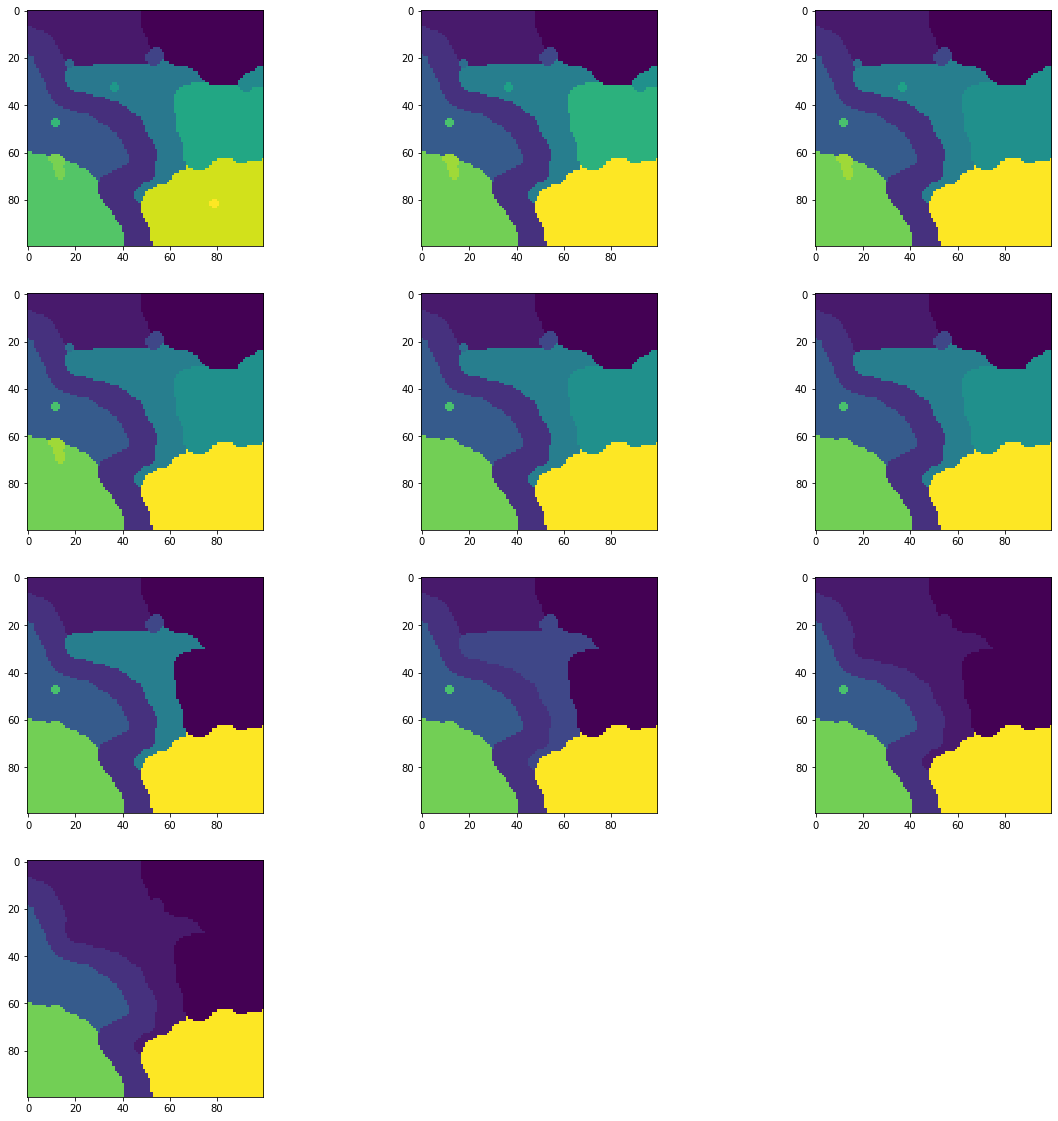

In [10]:
plt.figure(figsize=(20,20))
all_label1=np.copy(all_labels)
step_gen=(i for i in merger)
cntr=1
for i in step_gen:
    plt.subplot(4,3,cntr)
    all_label1[all_label1==i[1]]=i[0]
    plt.imshow(all_label1)
    cntr+=1